In [1]:
library(plyr)
library(dplyr)
library(forecast)
library(data.table)
library(tseries)
options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
user_balance=read.csv("Dataset/user_balance_table.csv")
user_balance$report_date=as.Date(as.character(user_balance$report_date),format="%Y%m%d")

temp=order(user_balance$report_date)
user_balance=user_balance[temp,]

data=ddply(user_balance,.(report_date),function(D){ colwise(sum)(D[,c(-1,-2)])})

train_data = data[274:396,]
test_data = data[397:427,]

In [3]:
get_score<- function(purchase_pred,redeem_pred,purchase_true,redeem_true,h=0.3){
  out = data.frame(purchase_pred ,redeem_pred,purchase_true,redeem_true )
  
  out$purchase_mape = abs(out$purchase_pred-out$purchase_true)/
    out$purchase_true
  out$redeem_mape = abs(out$redeem_pred-out$redeem_true)/
    out$redeem_true
  
  score = sum(exp(-out$purchase_mape/h)*10)* 0.45 + 
    sum(exp(-out$redeem_mape/h)*10)* 0.55 
  return(score)
}

In [4]:
#####purchase
purchase_ts=ts(train_data$total_purchase_amt,
               frequency=7,start=c(1,1))##生成时间序列
purchase_stl_res = stl(purchase_ts,s.window="periodic",robust=TRUE)##stl分解
purchase_pred_test = forecast(purchase_stl_res,h = 31)$mean##得到测试集预测结果



#####redeem
redeem_ts = ts(train_data$total_redeem_amt,
               frequency=7,start=c(1,1))
redeem_stl_res = stl(redeem_ts,s.window="periodic",robust=TRUE)
redeem_pred_test = forecast(redeem_stl_res,h = 31)$mean


get_score(purchase_pred_test,redeem_pred_test,test_data$total_purchase_amt,
          test_data$total_redeem_amt)


[1] 172.7222

In [5]:
purchase_del_ts=ts(purchase_ts-purchase_stl_res$time.series[,1],
                   frequency=7,start=c(1,1))

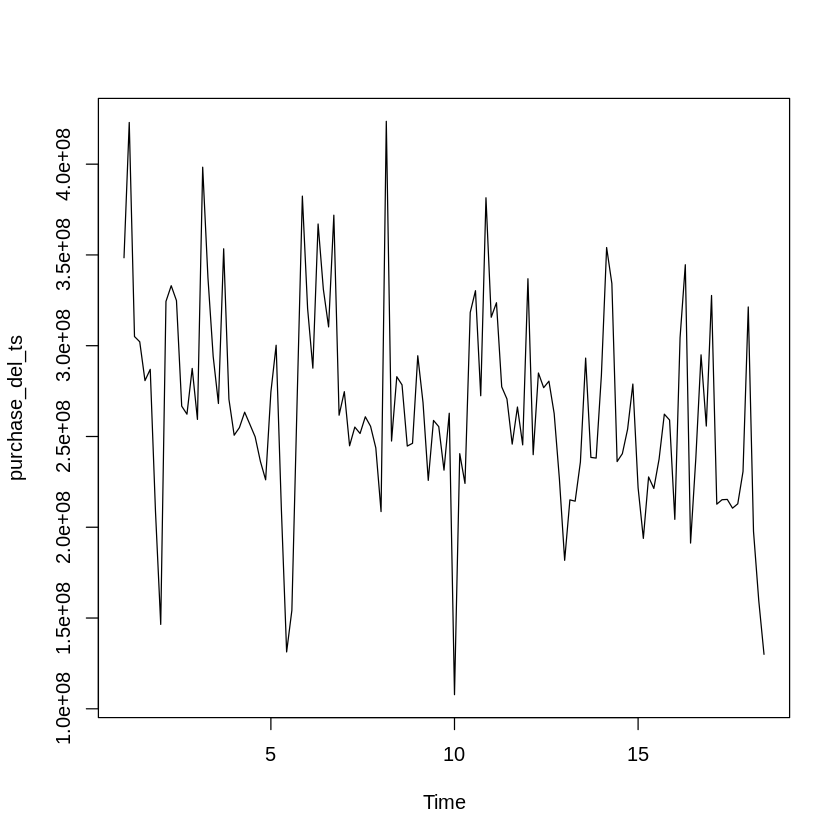

In [6]:
plot(purchase_del_ts)

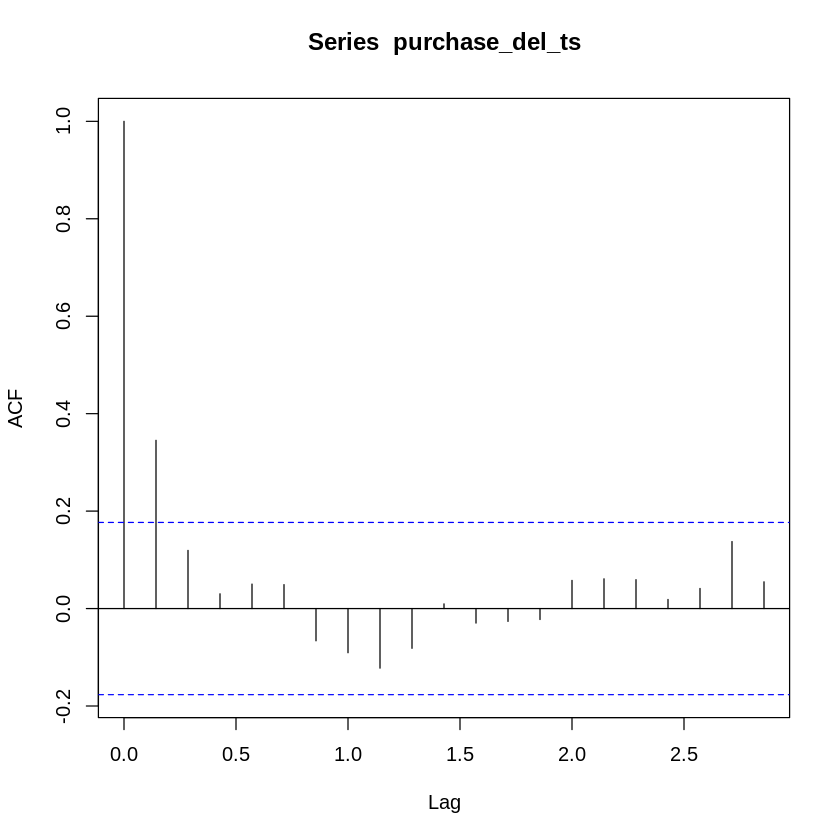

In [7]:
acf(purchase_del_ts)

In [8]:
adf.test(purchase_del_ts)


	Augmented Dickey-Fuller Test

data:  purchase_del_ts
Dickey-Fuller = -4.3948, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


In [9]:
for(i in 1:2){print(Box.test(purchase_del_ts,type = "Box-Pierce",
                             lag = i*6)$p.value)}
for(i in 1:2){print(Box.test(purchase_del_ts,type = "Ljung-Box",
                             lag = i*6)$p.value)}

[1] 0.007097898
[1] 0.04290397
[1] 0.005825161
[1] 0.03343909


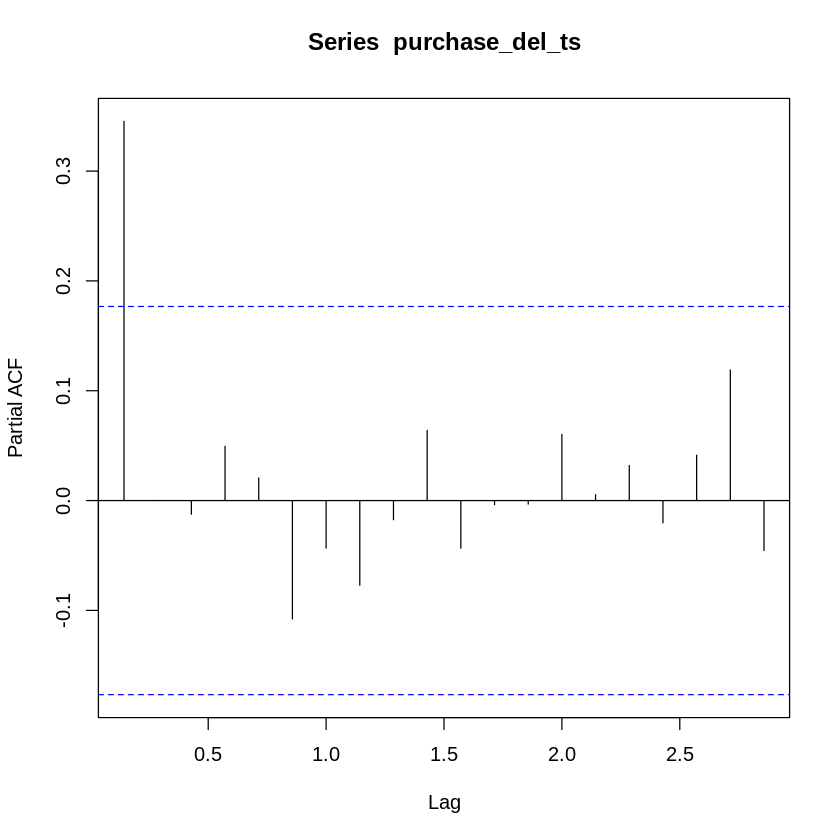

In [10]:
pacf(purchase_del_ts)#p，横轴从1开始

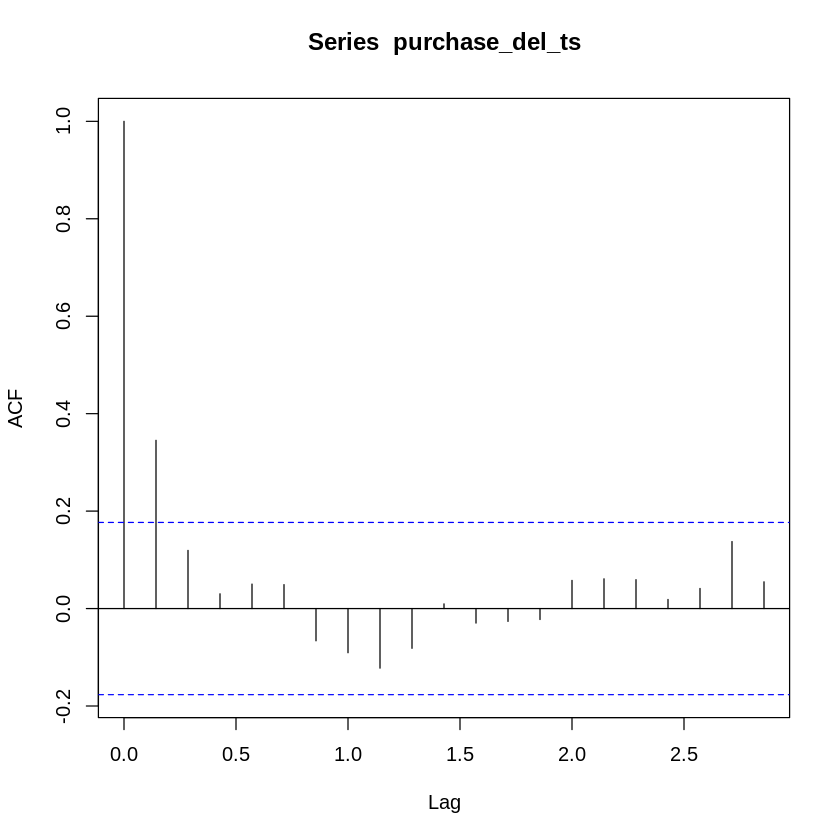

In [11]:
acf(purchase_del_ts)#q

In [12]:
purchase_del_fit = arima(purchase_del_ts/1000,order = c(1,0,1))

In [13]:
purchase_del_fit


Call:
arima(x = purchase_del_ts/1000, order = c(1, 0, 1))

Coefficients:
         ar1      ma1   intercept
      0.4187  -0.0593  265797.596
s.e.  0.2409   0.2584    7658.376

sigma^2 estimated as 2.784e+09:  log likelihood = -1512.04,  aic = 3032.09

In [14]:
for(i in 1:2){print(Box.test(purchase_del_fit$residuals,type = "Ljung-Box",
                             lag = i*6)$p.value)}
for(i in 1:2){print(Box.test(purchase_del_fit$residuals,type = 'Box-Pierce',
                             lag = i*6)$p.value)}

[1] 0.9691384
[1] 0.9876937
[1] 0.9734135
[1] 0.9914217


In [15]:
purchase_pred_test = forecast(purchase_stl_res$time.series[,1],31)$mean+
  predict(purchase_del_fit,n.ahead = 31)$pred*1000

In [16]:
#####redeem
redeem_del_ts=ts(redeem_ts-redeem_stl_res$time.series[,1],
                   frequency=7,start=c(1,1))

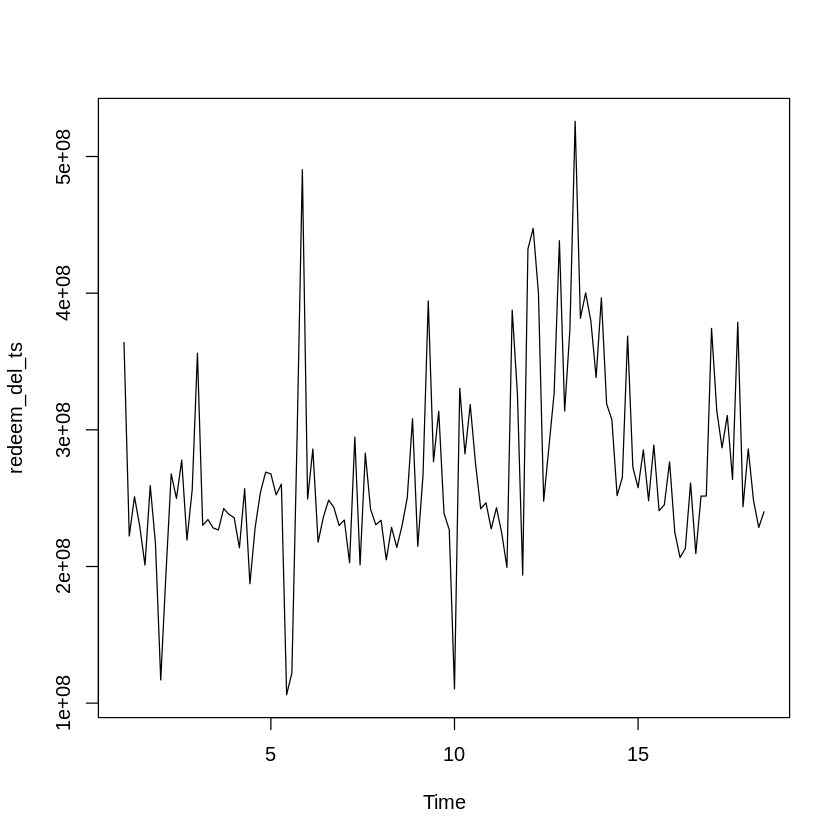

In [17]:
plot(redeem_del_ts)

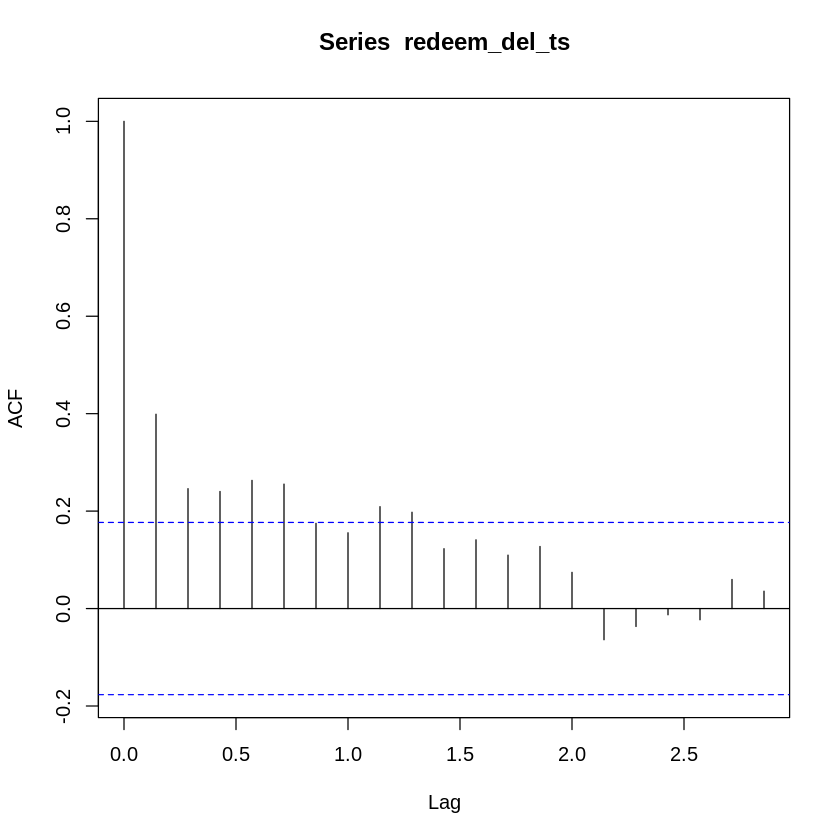

In [18]:
acf(redeem_del_ts)

In [19]:
adf.test(redeem_del_ts)



	Augmented Dickey-Fuller Test

data:  redeem_del_ts
Dickey-Fuller = -3.0508, Lag order = 4, p-value = 0.14
alternative hypothesis: stationary


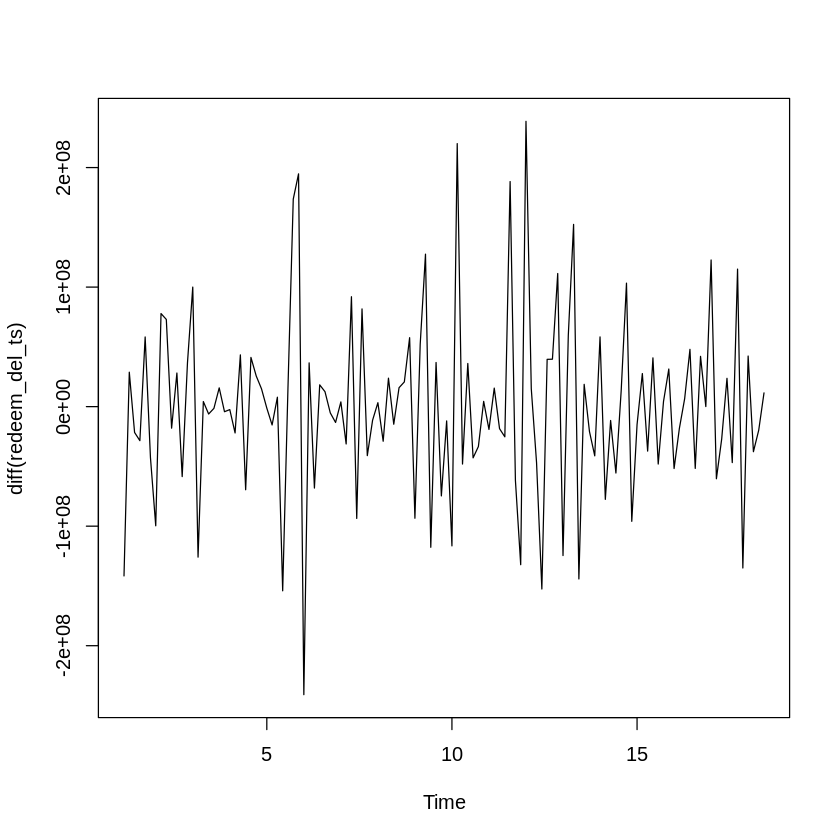

In [20]:
plot(diff(redeem_del_ts))##差分后的时序图

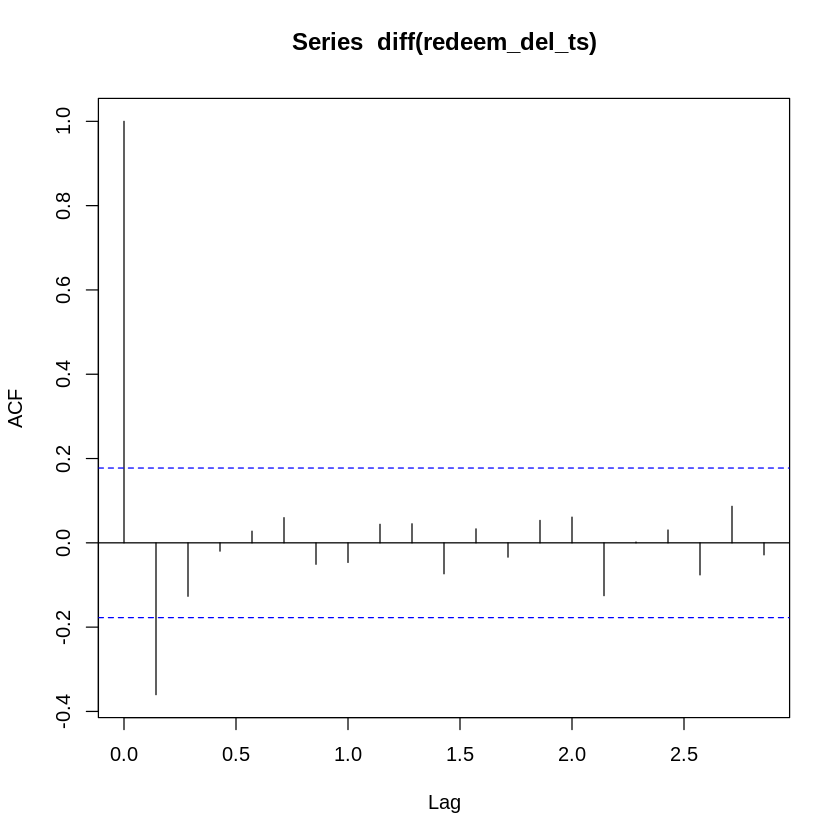

In [21]:
acf(diff(redeem_del_ts))

In [22]:
adf.test(diff(redeem_del_ts))


	Augmented Dickey-Fuller Test

data:  diff(redeem_del_ts)
Dickey-Fuller = -7.1293, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


In [23]:
for(i in 1:2){print(Box.test(diff(redeem_del_ts),type = "Box-Pierce",
                             lag = i*6)$p.value)}

for(i in 1:2){print(Box.test(diff(redeem_del_ts),type = "Ljung-Box",
                             lag = i*6)$p.value)}

[1] 0.004738446
[1] 0.0605687
[1] 0.003849948
[1] 0.04976641


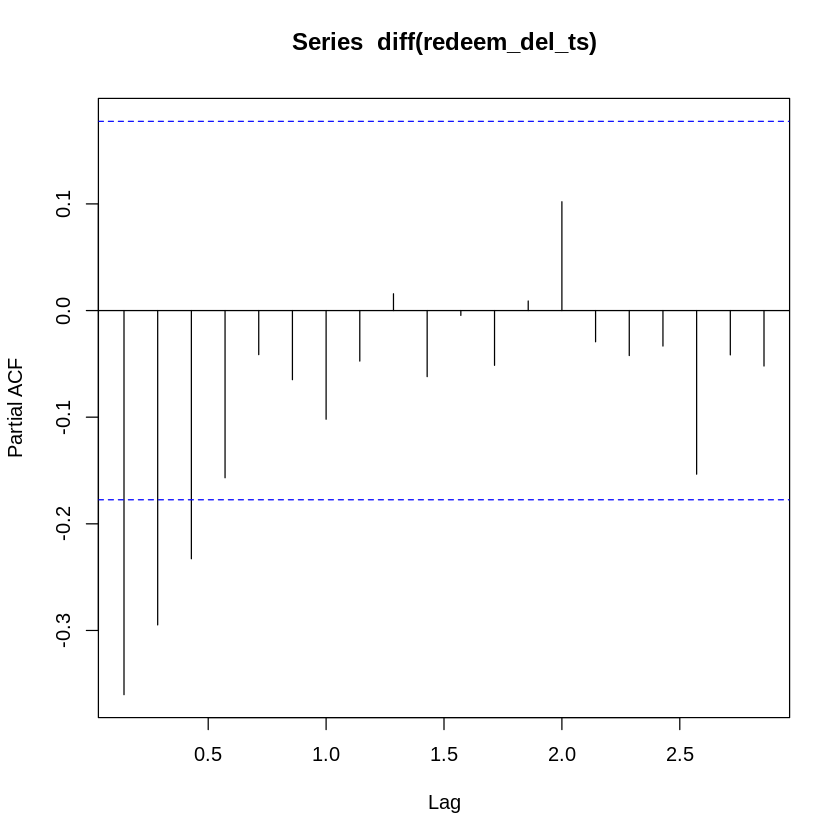

In [24]:
pacf(diff(redeem_del_ts))#拖尾

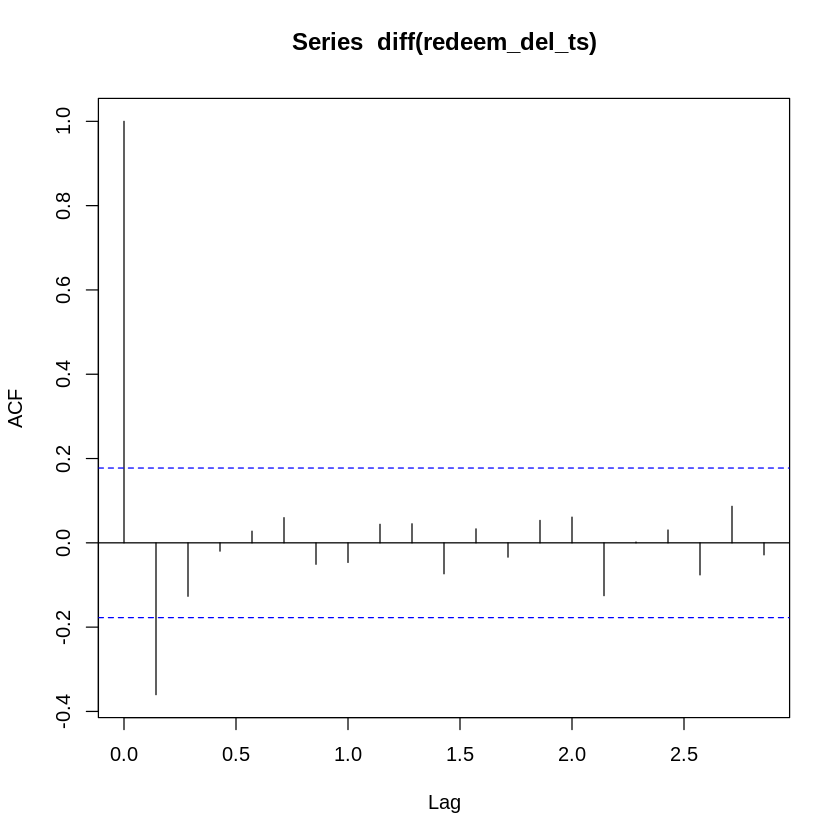

In [25]:
acf(diff(redeem_del_ts)) #截尾

In [26]:
redeem_del_fit = arima(redeem_del_ts,order = c(0,1,1))####建模

In [27]:
###模型显著性检验====
for(i in 1:2){print(Box.test(redeem_del_fit$residuals,
                             type = "Ljung-Box",lag = i*6)$p.value)}


for(i in 1:2){print(Box.test(redeem_del_fit$residuals,
                             type = 'Box-Pierce',lag = i*6)$p.value)}

[1] 0.7397571
[1] 0.9739962
[1] 0.7547025
[1] 0.9783781


In [28]:
redeem_pred_test = predict(redeem_del_fit,n.ahead = 31)$pred+
  forecast(redeem_stl_res$time.series[,1],h=31)$mean

In [29]:
get_score(purchase_pred_test,redeem_pred_test,test_data$total_purchase_amt,
          test_data$total_redeem_amt)

[1] 191.2307

In [30]:
#####去除周期后 auto.arima
#####purchase======
autoFit = auto.arima(purchase_del_ts/1000,d=0,seasonal = F,trace = T )


 ARIMA(2,0,2)           with non-zero mean : 3036.781
 ARIMA(0,0,0)           with non-zero mean : 3044.866
 ARIMA(1,0,0)           with non-zero mean : 3030.344
 ARIMA(0,0,1)           with non-zero mean : 3032.692
 ARIMA(0,0,0)           with zero mean     : 3429.418
 ARIMA(2,0,0)           with non-zero mean : 3032.426
 ARIMA(1,0,1)           with non-zero mean : 3032.428
 ARIMA(2,0,1)           with non-zero mean : 3034.588
 ARIMA(1,0,0)           with zero mean     : 3074.01

 Best model: ARIMA(1,0,0)           with non-zero mean 



In [31]:
for(i in 1:2){print(Box.test(autoFit$residuals,type = "Ljung-Box",lag = i*6)$p.value)}
for(i in 1:2){print(Box.test(autoFit$residuals,type = 'Box-Pierce',lag = i*6)$p.value)}

[1] 0.9697502
[1] 0.9881997
[1] 0.9739763
[1] 0.9917919


In [32]:
purchase_pred_test = forecast(purchase_stl_res$time.series[,1],31)$mean+
  forecast(autoFit,h=31)$mean*1000

In [33]:
autoFit = auto.arima(redeem_del_ts,d=1,seasonal = F,trace = TRUE)


 ARIMA(2,1,2)           with drift         : 4746.025
 ARIMA(0,1,0)           with drift         : 4781.675
 ARIMA(1,1,0)           with drift         : 4766.45
 ARIMA(0,1,1)           with drift         : 4742.536
 ARIMA(0,1,0)                              : 4779.628
 ARIMA(1,1,1)           with drift         : 4741.796
 ARIMA(2,1,1)           with drift         : 4743.756
 ARIMA(1,1,2)           with drift         : 4743.779
 ARIMA(0,1,2)           with drift         : 4741.605
 ARIMA(0,1,3)           with drift         : 4743.777
 ARIMA(1,1,3)           with drift         : 4745.991
 ARIMA(0,1,2)                              : 4739.482
 ARIMA(0,1,1)                              : 4740.435
 ARIMA(1,1,2)                              : 4741.617
 ARIMA(0,1,3)                              : 4741.616
 ARIMA(1,1,1)                              : 4739.681
 ARIMA(1,1,3)                              : 4743.793

 Best model: ARIMA(0,1,2)                              



In [34]:
###模型显著性检验====
for(i in 1:2){print(Box.test(autoFit$residuals,type = "Ljung-Box",lag = i*6)$p.value)}
for(i in 1:2){print(Box.test(autoFit$residuals,type = 'Box-Pierce',lag = i*6)$p.value)}

[1] 0.9896333
[1] 0.9995391
[1] 0.9910407
[1] 0.9996895


In [35]:
redeem_pred_test = forecast(autoFit,h=31)$mean+
  forecast(redeem_stl_res$time.series[,1],h=31)$mean

In [36]:
get_score(purchase_pred_test,redeem_pred_test,test_data$total_purchase_amt,
          test_data$total_redeem_amt)

[1] 190.4957

In [37]:
holidays_and_effect_days <- data_frame(
  holiday = 'holidays_and_effect_days',
  ds = as.Date(c('2014-04-03', '2014-04-04', 
                 '2014-04-05', '2014-04-06', '2014-04-07', 
                 '2014-04-08', '2014-04-09',
                 
                 '2014-04-29', '2014-04-30', 
                 '2014-05-01', '2014-05-02', '2014-05-03',
                 '2014-05-04', '2014-05-05',
                 
                 '2014-05-29', '2014-05-30',
                 '2014-05-31', '2014-06-01', '2014-06-02', 
                 '2014-06-03', '2014-06-04')),
  lower_window = 0,
  upper_window = 0
)

holidays <- data_frame(
  holiday = 'true_holidays',
  ds = as.Date(c('2014-04-05', '2014-04-06', '2014-04-07',
                 '2014-05-01', '2014-05-02', '2014-05-03',
                 '2014-05-31', '2014-06-01', '2014-06-02')),
  lower_window = 0,
  upper_window = 0
)
holidays <- bind_rows(holidays_and_effect_days, holidays)



###purchase=========

Myprophet_purchase = prophet::prophet(changepoint_prior_scale=0.5,weekly_seasonality=T,
                                      holidays= holidays)
df_purchase = data.frame(train_data$report_date ,train_data$total_purchase_amt )
colnames(df_purchase) <-c('ds','y')
Myprophet_purchase = prophet::fit.prophet(Myprophet_purchase,df_purchase)

future_purchase = prophet::make_future_dataframe(Myprophet_purchase,periods=31,
                                                 include_history=F)
forecast_purchase = predict(Myprophet_purchase, future_purchase)
purchase_pred_test = forecast_purchase$yhat



###redeem=====
Myprophet_redeem = prophet::prophet(changepoint_prior_scale=0.5,weekly_seasonality=True,
                                    holidays= holidays)
df_redeem = data.frame(train_data$report_date ,train_data$total_redeem_amt )
colnames(df_redeem) <-c('ds','y')
df_redeem
Myprophet_redeem = prophet::fit.prophet(Myprophet_redeem,df_redeem)

future_redeem = prophet::make_future_dataframe(Myprophet_redeem,periods=31,
                                               include_history=F)
forecast_redeem = predict(Myprophet_redeem, future_redeem)
redeem_pred_test = forecast_redeem$yhat

get_score(purchase_pred_test,redeem_pred_test,test_data$total_purchase_amt,
          test_data$total_redeem_amt)


ERROR: Error in loadNamespace(name): there is no package called ‘prophet’
